In [1]:
%load_ext cython
%matplotlib inline

import math
import statistics
import timeit
from collections import defaultdict

import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import Angle

import numpy as np

In [2]:
%%cython

cimport cython
from libc cimport math


@cython.cdivision(True)
def div(float angle, float period):
    cdef int wraps
    wraps = <int> math.floor(angle / period)
    return wraps

@cython.cdivision(True)
def div2(float angle, float period):
    cdef int wraps
    wraps = int(angle // period)
    return wraps

In [3]:
div(10, 3), div(10, 2)

(3, 5)

In [4]:
div2(10, 3), div2(10, 2)

(3, 5)

In [5]:
%timeit div(10, 3)

48.8 ns ± 4.12 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [6]:
%timeit div2(10, 3)

44.1 ns ± 2.35 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [7]:
def ref_wrap_at(self_angle, wrap_angle, a360):
    wrap_angle = float(wrap_angle)
    wrap_angle_floor = wrap_angle - a360
    # Do the wrapping, but only if any angles need to be wrapped
    #
    # Catch any invalid warnings from the floor division.

    # See if any wrapping is necessary and return early otherwise.
    # It is useful to avoid this since the array may be read-only
    # (e.g. due to broadcasting).
    # Note that since comparisons with NaN always return False,
    # this also ensures that no adjustments are made for a
    # read-only array with some NaN but otherwise OK elements.
    out_of_range = (self_angle < wrap_angle_floor) | (self_angle >= wrap_angle)
    if not out_of_range.any():
        return

    wraps = (self_angle - wrap_angle_floor) // a360

    self_angle -= wraps * a360
    # Rounding errors can cause problems.
    self_angle[self_angle >= wrap_angle] -= a360
    self_angle[self_angle < wrap_angle_floor] += a360
    return self_angle

In [8]:
%%cython -3

cimport cython
from libc cimport math

cimport numpy as np

np.import_array()

ctypedef fused dtype:
    short
    int
    long
    float
    double


@cython.ufunc
@cython.cdivision(True)
cdef dtype wrap_at(dtype angle, dtype wrap_angle, dtype period):
    cdef dtype wrap_angle_floor
    wrap_angle_floor = wrap_angle - period

    if dtype is float or dtype is double:
        if math.isnan(angle):
            return angle

    if (angle >= wrap_angle_floor) and (angle < wrap_angle):
        return angle

    cdef int wraps
    wraps = <int> math.floor((angle - wrap_angle_floor) / period)

    angle -= wraps * period

    # Rounding errors can cause problems.
    if angle >= wrap_angle:
        angle -= period
    elif angle < wrap_angle_floor:
        angle += period

    return angle

In [9]:
arr = np.random.uniform(0, 10_000, size=1_000_000)

In [10]:
arr

array([8309.71687369, 8531.17005931, 7180.25942512, ..., 5439.42968179,
       4590.65909066, 6865.6230479 ])

In [11]:
wrap_at(arr, 1200, 360)

array([1109.71687369,  971.17005931, 1060.25942512, ..., 1119.42968179,
        990.65909066, 1105.6230479 ])

In [12]:
ref_wrap_at(arr, 1200, 360)

array([1109.71687369,  971.17005931, 1060.25942512, ..., 1119.42968179,
        990.65909066, 1105.6230479 ])

In [13]:
%timeit ref_wrap_at(arr.copy(), 1200, 360)

718 µs ± 75.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
%timeit wrap_at(arr.copy(), 1200, 360)

3.41 ms ± 399 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
arr = np.random.uniform(0, 10_000, size=1_000_000).astype(int)

In [16]:
arr

array([3636, 5837, 2687, ..., 2029, 5955, 9622])

In [17]:
wrap_at(arr, 1200.5, 360)

array([1116., 1157.,  887., ...,  949.,  915.,  982.])

In [18]:
arr

array([3636, 5837, 2687, ..., 2029, 5955, 9622])

In [19]:
Angle(arr, unit="deg").value

array([3636., 5837., 2687., ..., 2029., 5955., 9622.])

In [20]:
Angle(arr, unit="deg").wrap_at(1200.5 * u.deg).value

array([1116., 1157.,  887., ...,  949.,  915.,  982.])

In [21]:
%%cython -3

cimport cython
from libc cimport math


@cython.cdivision(True)
def wrap_at2(double[:] angle_arr, double wrap_angle, double period):

    cdef int wraps
    cdef ssize_t i
    cdef double wrap_angle_floor = wrap_angle - period

    for i in range(angle_arr.shape[0]):        
        if math.isnan(angle_arr[i]):
            continue
    
        if (angle_arr[i] >= wrap_angle_floor) and (angle_arr[i] < wrap_angle):
            continue
    
        wraps = int((angle_arr[i] - wrap_angle_floor) // period)
        angle_arr[i] -= wraps * period
    
        # Rounding errors can cause problems.
        if angle_arr[i] >= wrap_angle:
            angle_arr[i] -= period
        elif angle_arr[i] < wrap_angle_floor:
            angle_arr[i] += period

In [22]:
arr = np.random.uniform(0, 10_000, size=1_000_000)

In [23]:
arr

array([9532.29516847, 1316.79333318, 1043.80320951, ..., 5266.88657292,
       9284.51925962, 7062.48147958])

In [24]:
wrap_at(arr, 1200, 360)

array([ 892.29516847,  956.79333318, 1043.80320951, ...,  946.88657292,
       1004.51925962,  942.48147958])

In [25]:
wrap_at2(arr, 1200, 360)

In [26]:
arr

array([ 892.29516847,  956.79333318, 1043.80320951, ...,  946.88657292,
       1004.51925962,  942.48147958])

In [27]:
arr = np.random.uniform(0, 10_000, size=1_000_000)

In [28]:
%timeit wrap_at(arr.copy(), 1200, 360)

4.57 ms ± 227 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
%timeit wrap_at2(arr.copy(), 1200, 360)

2.6 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
%timeit ref_wrap_at(arr.copy(), 1200, 360)

12.4 ms ± 461 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
timeit.repeat(
    "func(arr.copy(), 1200, 360)",
    globals=dict(arr=arr, func=wrap_at),
    number=100,
    repeat=7,
)

[0.6674293360265438,
 0.5732990489923395,
 0.5062652619963046,
 0.5035934560000896,
 0.4982092760037631,
 0.5077174689795356,
 0.5026208050257992]

In [34]:
timeit.repeat(
    "func(arr.copy(), 1200, 360)",
    globals=dict(arr=arr, func=wrap_at2),
    number=100,
    repeat=7,
)

[0.40831955400062725,
 0.3157323370105587,
 0.2744517360115424,
 0.2941159599868115,
 0.3032113120134454,
 0.292810429004021,
 0.2840978409803938]

In [35]:
number, repeat = 100, 7

funcs = dict(ref=ref_wrap_at, ufunc=wrap_at, memview=wrap_at2)
times = defaultdict(list)
sizes = np.geomspace(1e2, 1e7, 6)

for size in sizes:
    size = int(size)
    print(f"{size}:", end=" ")
    arr = np.random.uniform(0, 10_000, size=size)

    for name, func in funcs.items():
        print(name, end=" ")
        time = timeit.repeat(
            "func(arr.copy(), 1200, 360)",
            globals=dict(arr=arr, func=func),
            number=number,
            repeat=repeat,
        )
        time = np.array(time[2:]) / number
        times[name].append((np.mean(time), np.std(time)))
    print()

100: ref ufunc memview 
1000: ref ufunc memview 
10000: ref ufunc memview 
100000: ref ufunc memview 
1000000: ref ufunc memview 
10000000: ref ufunc memview 


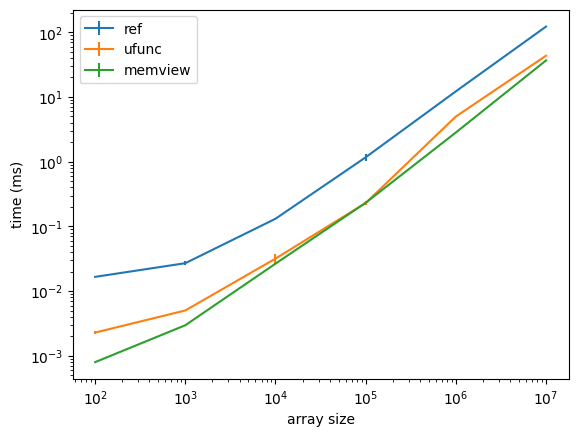

In [36]:
fig, ax = plt.subplots()
for name, time in times.items():
    time = np.array(time)
    ax.errorbar(sizes, time[:, 0] * 1e3, yerr=time[:, 1] * 1e3, label=name)
ax.set(xlabel="array size", ylabel="time (ms)", xscale="log", yscale="log")
ax.legend();